In [1]:
# import general classes for data processing
import ruptures as rpt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

# import custom classes 
from model import Signal, GestureRecognitionModel
from model import GestureRecognitionDataset

# import SVM classes
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import StandardScaler

# import MLP
from sklearn.neural_network import MLPClassifier

# import for loop and XGboost
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# import ensemble function
from sklearn.ensemble import VotingClassifier

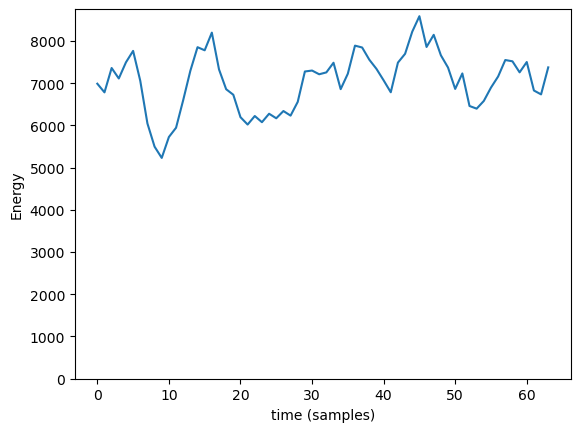

In [5]:

signal = Signal(path_to_file=path_to_file)
#  add zeros to signal
num_zeros = 10 
zeros_to_add = np.zeros((num_zeros, signal.signal.shape[1]))  # Assuming signal.signal is a 2D array
signal.signal = np.concatenate((zeros_to_add, signal.signal), axis=0)

signal.remove_transition(algorithm="Binseg")

# Now 'signal' contains the signal after the change point
signal.display(attr="energy", w=5)

10


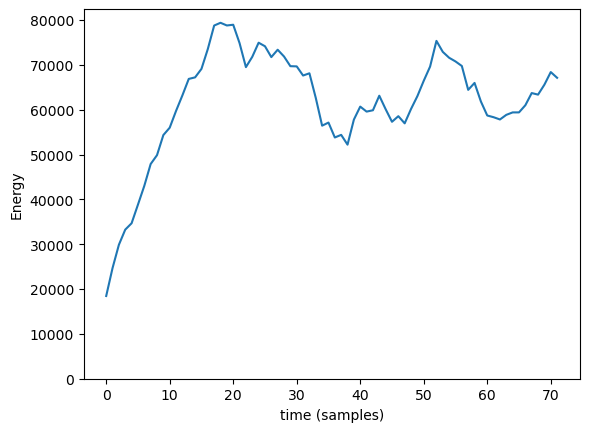

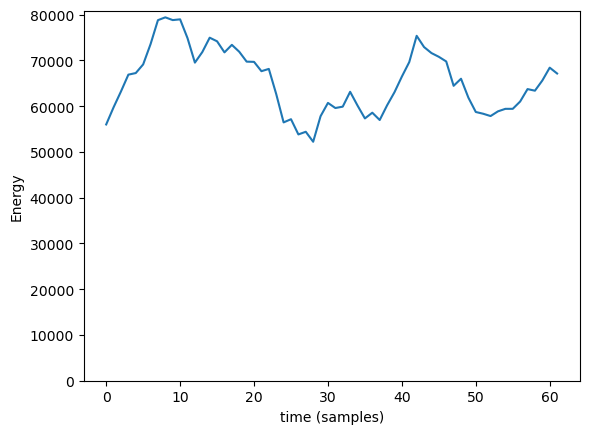

In [421]:
# do not run, results stored for meeting

signalpath_notransition = "data\Mario2\ClosedHand_3.npy"
min_s = 10
transition = "on"
add_transition = "off"

if transition == "on":
    path_to_file = "data\dataJoel\Joel1\ThumbAbduction_3.npy"
else:
    path_to_file = signalpath_notransition

signal = Signal(path_to_file=path_to_file)

if add_transition == "on":
    num_zeros = 25
    zeros_to_add = np.zeros((num_zeros, signal.signal.shape[1]))  # assuming signal.signal is a 2D array
    signal.signal = np.concatenate((zeros_to_add, signal.signal), axis=0)
else:
    signal.signal = signal.signal 

signal.display(attr="energy", w=5)

step = 10

# initialize change point detection with Pelt
s = signal.get_features(list_features=["mav"]).sum(axis=1)

algo = rpt.Pelt(model="l2", min_size=min_s).fit(s)
result = algo.predict(pen=20)[0]
print(result)
limit = (0.25*signal.signal.shape[0])/step

if result > limit:
    result = round((0*signal.signal.shape[0])/step)

trans_idx = result*step

# remove phase of transition
signal.signal = signal.signal[trans_idx:, :]
signal.n_samples = signal.signal.shape[0]

signal.display(attr="energy", w=5)

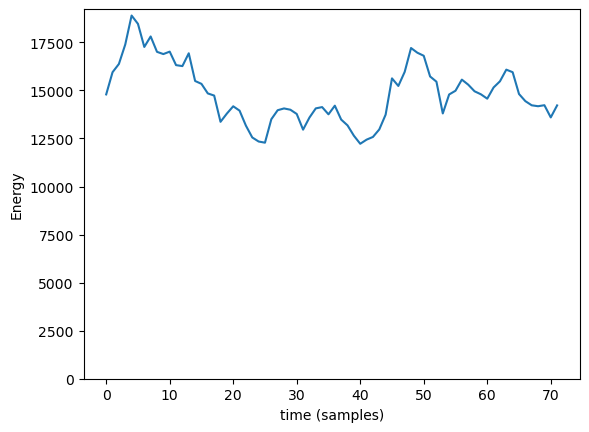

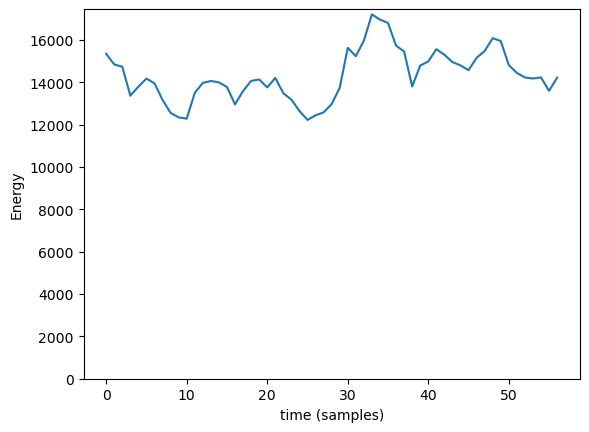

In [459]:
# do not run, results stored for meeting

signalpath_notransition = "data\Mario2\ClosedHand_3.npy"
min_s = 10

transition = "off"
add_transition = "off"

if transition == "on":
    path_to_file = "data\dataJoel\Joel1\ThumbAbduction_3.npy"
else:
    path_to_file = signalpath_notransition

signal = Signal(path_to_file=path_to_file)

if add_transition == "on":
    num_zeros = 25
    zeros_to_add = np.zeros((num_zeros, signal.signal.shape[1]))  # assuming signal.signal is a 2D array
    signal.signal = np.concatenate((zeros_to_add, signal.signal), axis=0)
else:
    signal.signal = signal.signal 
    
signal.display(attr="energy", w=5)
step = 10

limit = (0.25*signal.signal.shape[0])/step 
result = signal.signal.shape[0]/step

while result > limit:
    min_s -= 1 
    if min_s < 1: 
        break

    # initialize change point detection with Pelt
    s = signal.get_features(list_features=["mav"]).sum(axis=1)

    algo = rpt.Pelt(model="l2", min_size=min_s).fit(s)
    result = algo.predict(pen=20)[0]

if result < limit:

    trans_idx = result*step

    # remove phase of transition
    signal.signal = signal.signal[trans_idx:, :]
    signal.n_samples = signal.signal.shape[0]

    signal.display(attr="energy", w=5)

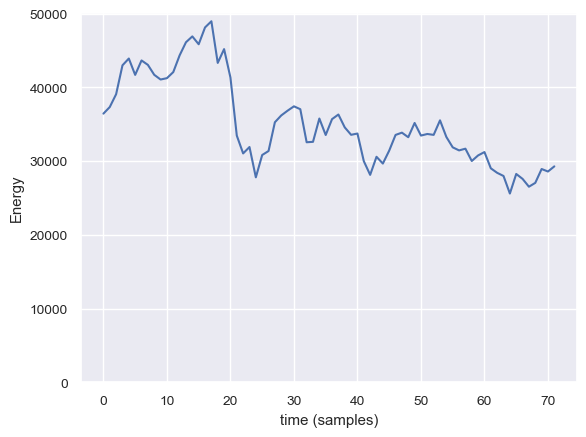

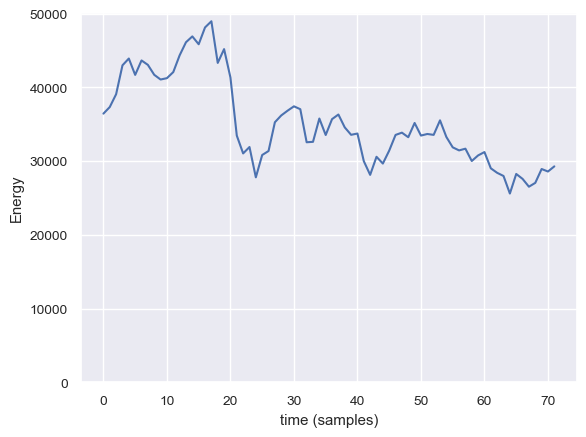

In [33]:
path_to_file = "data\Mario2\ThumbAbduction_1.npy"
step = 10

signal = Signal(path_to_file=path_to_file)
signal.display(attr="energy", w=5)
signal.remove_transition(algorithm="mean")
signal.display(attr="energy", w=5)

In [2]:
# testing initial model on this new data

# initialize dataset 
path_to_dataset = "data"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,             ## what is different in v1? Got no gestures in v2
                                    version="v1", save_df=False, 
                                    remove_transition=True)

df = gr.get_features()



100%|██████████| 2102/2102 [03:49<00:00,  9.18it/s]


In [85]:
subject = 'Aarushi'
Take_to_test = '3'

df = df[(df['subject'] == subject)]

In [88]:
#selecting X (features) and Y (gestures) 
# instantiate the model 

model_type = "xgboost"
#kernel = "rbf"
model = GestureRecognitionModel(model_name=model_type)

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

# here I tested if the length of the features had any influence on the accuracy, this was not the case, so this can be skipped. 
# Find the length of the shortest column
#min_length = min(len(df[column]) for column in columns_x)

# Truncate each column to the length of the shortest column
#columns_x = [column[:min_length] for column in columns_x]

df_train = df[(df['take'] != Take_to_test)]
df_test = df[(df['take'] == Take_to_test)]

# Downsampling the "neutral" class in the training set
#neutral_df = df_train[df_train['gesture'] == 'Neutral']
#non_neutral_df = df_train[df_train['gesture'] != 'Neutral']

# Randomly sample 1/3 of the "neutral" class instances
#neutral_downsampled = neutral_df.sample(frac=1/3)

# Concatenate the downsampled neutral class with the rest of the training data
#df_train = pd.concat([non_neutral_df, neutral_downsampled])

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

'''
if kernel == 'linear' or kernel == 'sigmoid':
       scaler = StandardScaler() 
       X_train = scaler.fit_transform(X_train)
       X_test = scaler.transform(X_test)
else: 
       X_train = X_train
       X_test = X_test
'''

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.train(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 76.78%


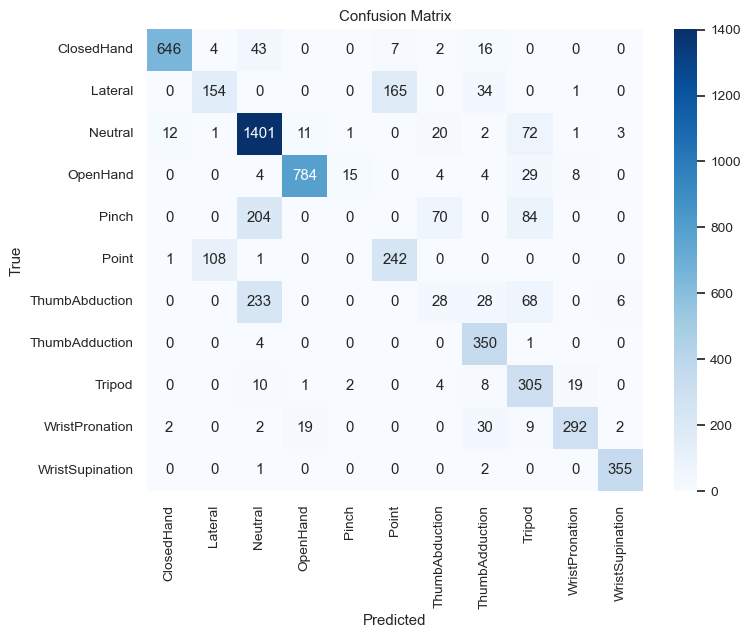

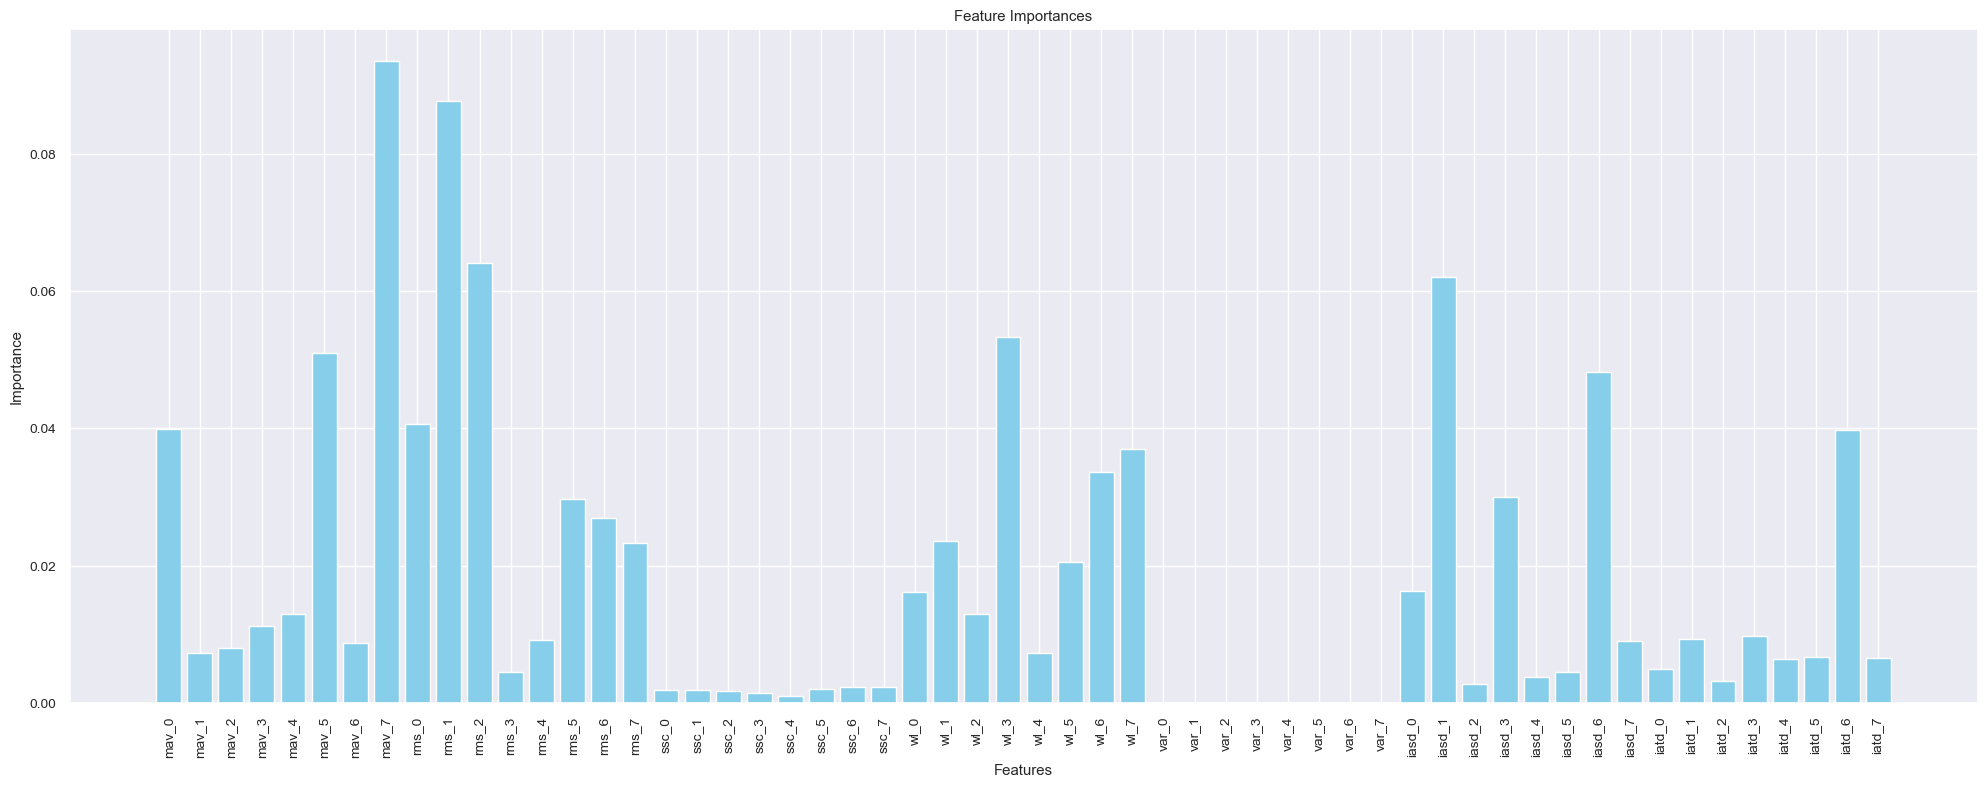

In [89]:
# plotting confusion matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Get class labels
class_labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)  # Adjust to fit labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

feature_importances = model.model.feature_importances_
features = ['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']


plt.figure(figsize=(20, 8))
plt.bar(features, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [57]:
# testing treating of class imbalance

#selecting X (features) and Y (gestures) 

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

# here I tested if the length of the features had any influence on the accuracy, this was not the case, so this can be skipped. 
# Find the length of the shortest column
#min_length = min(len(df[column]) for column in columns_x)

# Truncate each column to the length of the shortest column
#columns_x = [column[:min_length] for column in columns_x]

df_train = df[(df['take'] != Take_to_test)]
df_test = df[(df['take'] == Take_to_test)]

# Downsampling the "neutral" class in the training set
neutral_df = df_train[df_train['gesture'] == 'Neutral']
non_neutral_df = df_train[df_train['gesture'] != 'Neutral']

# Randomly sample 1/3 of the "neutral" class instances
neutral_downsampled = neutral_df.sample(frac=1/3)

# Concatenate the downsampled neutral class with the rest of the training data
df_train = pd.concat([non_neutral_df, neutral_downsampled])

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

if kernel == 'linear' or kernel == 'sigmoid':
       scaler = StandardScaler() 
       X_train = scaler.fit_transform(X_train)
       X_test = scaler.transform(X_test)
else: 
       X_train = X_train
       X_test = X_test

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.train(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))


The accuracy of the model is 83.05%


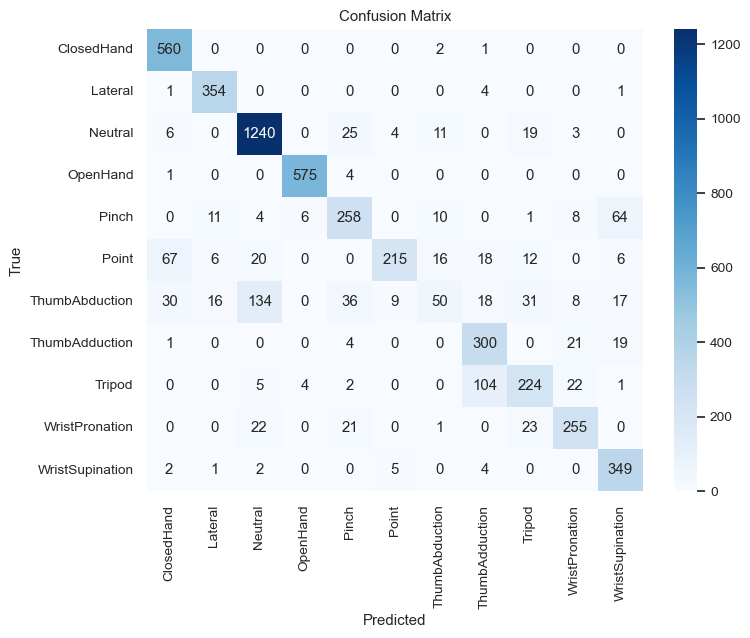

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [58]:
# plotting confusion matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Get class labels
class_labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)  # Adjust to fit labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

feature_importances = model.model.feature_importances_
features = ['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']


plt.figure(figsize=(20, 8))
plt.bar(features, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [3]:
# testing initial model on this new data

# initialize dataset 
path_to_dataset = "data"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,             ## what is different in v1? Got no gestures in v2
                                    version="v1", save_df=False, 
                                    remove_transition=True)

df = gr.get_features()

  0%|          | 0/2102 [00:00<?, ?it/s]

100%|██████████| 2102/2102 [04:15<00:00,  8.22it/s]


In [10]:
df.head()

,mav_0,mav_1,mav_2,mav_3,mav_4,mav_5,mav_6,mav_7,rms_0,rms_1,...,iatd_2,iatd_3,iatd_4,iatd_5,iatd_6,iatd_7,gesture,subject,take,timestamp
0,1.88,1.72,2.16,5.14,4.54,8.04,4.62,2.24,2.340940,2.097618,...,489.0,1471.0,1103.0,2066.0,1326.0,611.0,,Aarushi,1,ClosedHand_0
1,2.12,1.84,2.10,4.94,4.58,11.10,5.40,3.02,2.828427,2.441311,...,463.0,1275.0,1263.0,2715.0,1496.0,741.0,,Aarushi,1,ClosedHand_0
2,2.32,1.84,2.12,4.94,5.50,15.86,8.12,3.96,3.168596,2.433105,...,508.0,1378.0,1396.0,3662.0,2131.0,1015.0,,Aarushi,1,ClosedHand_0
3,2.38,1.98,2.00,4.88,5.92,16.84,9.30,4.04,3.258834,2.565151,...,476.0,1359.0,1544.0,3959.0,2282.0,1062.0,,Aarushi,1,ClosedHand_0
4,2.56,2.12,1.88,4.76,6.44,19.50,10.28,4.06,3.492850,2.698148,...,454.0,1344.0,1770.0,4398.0,2274.0,1018.0,,Aarushi,1,ClosedHand_0


In [9]:
subject = 'Aarushi'
Take_to_test = '3'

df2 = df[(df['subject'] == subject)]

In [84]:
# testing different parameters

model = SVC(kernel="rbf",degree = 2, C = 10)#, class_weight='balanced')

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

# here I tested if the length of the features had any influence on the accuracy, this was not the case, so this can be skipped. 
# Find the length of the shortest column
#min_length = min(len(df[column]) for column in columns_x)

# Truncate each column to the length of the shortest column
#columns_x = [column[:min_length] for column in columns_x]

df_train = df2[(df2['take'] != Take_to_test)]
df_test = df2[(df2['take'] == Take_to_test)]

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

'''
if kernel == 'linear' or kernel == 'sigmoid':
       scaler = StandardScaler() 
       X_train = scaler.fit_transform(X_train)
       X_test = scaler.transform(X_test)
else: 
       X_train = X_train
       X_test = X_test
'''

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.fit(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 75.96%


In [22]:
# testing initial model on this new data

# initialize dataset 
path_to_dataset = "data"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,             ## what is different in v1? Got no gestures in v2
                                    version="v1", save_df=False, 
                                    remove_transition=True)

df = gr.get_features()

100%|██████████| 2102/2102 [02:12<00:00, 15.92it/s]


In [30]:
# deleted corrected xgboost, no additional accuracy

models = {"xgboost_c1":XGBClassifier(),
          "poly_c1": SVC(kernel="poly",degree = 2, C = 1),
          "poly_c10": SVC(kernel="poly",degree = 2, C = 10),
          "rbf_c1": SVC(kernel="rbf",degree = 2, C = 1),
          "rbf_c10": SVC(kernel="rbf",degree = 2, C = 10),
          "poly_c1_corr": SVC(kernel="poly",degree = 2, C = 1, class_weight='balanced'),
          "poly_c10_corr": SVC(kernel="poly",degree = 2, C = 10, class_weight='balanced'),
          "rbf_c1_corr": SVC(kernel="rbf",degree = 2, C = 1, class_weight='balanced'),
          "rbf_c10_corr": SVC(kernel="rbf",degree = 2, C = 10, class_weight='balanced'),
          }  

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']


test_sets = [1, 2, 3]
subjects = list(df.subject.unique())
subjects.remove("Mario")
subjects.remove("Hanaa")

results = {model:[] for model in models}


for subject in tqdm(subjects):
    for model in models:
        for test_set in test_sets:

        
            df2 = df[(df['subject'] == subject)]

            df_train = df2[(df2['take'] != str(test_set))]
            df_test = df2[(df2['take'] == str(test_set))]

            print(df_train.shape,df_test.shape)

            X_train = df_train[selected_columns]
            y_train = df_train['gesture']
            X_test = df_test[selected_columns]
            y_test = df_test['gesture']

            label_encoder = LabelEncoder()
            Y_encoded = label_encoder.fit_transform(y_train)
            y_train = Y_encoded 

            Y_encoded2 = label_encoder.fit_transform(y_test)
            y_test = Y_encoded2 

            # training model
            models[model].fit(X_train, y_train)

            # making predictions with the testing subset
            y_pred = models[model].predict(X_test)

            # decoding y 
            predictions = [round(value) for value in y_pred]
            predicted_labels_decoded = label_encoder.inverse_transform(predictions)

            # calculate and print accuracy
            acc = accuracy_score(y_test, predictions)*100
            
            results[model].append(acc)

results = pd.DataFrame(results)


  0%|          | 0/9 [00:00<?, ?it/s]

(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(11432, 60) (4597, 60)
(10532, 60) (5497, 60)
(10094, 60) (5935, 60)
(9122, 60) (4551, 60)
(9101, 60) (4572, 60)
(9123, 60) (4550, 60)
(9122, 60) (4551, 60)
(9101, 60) (4572, 60)
(9123, 60) (4550, 60)
(9122, 60) (4551, 60)
(9101, 60) (4572, 60)
(9123, 60) (4550, 60)
(9122, 60) (4551, 60)
(9101, 60) (4572, 60)
(9123, 60) (4550, 60)
(9122, 60) (4551, 60)
(9101, 60) (4572, 60)
(9123, 60) (4550, 60)
(9122, 60) (4551, 60)
(9101, 60) (4572, 60)
(9123

[Text(0, 0, 'xgboost_c1'),
 Text(1, 0, 'poly_c1'),
 Text(2, 0, 'poly_c10'),
 Text(3, 0, 'rbf_c1'),
 Text(4, 0, 'rbf_c10'),
 Text(5, 0, 'poly_c1_corr'),
 Text(6, 0, 'poly_c10_corr'),
 Text(7, 0, 'rbf_c1_corr'),
 Text(8, 0, 'rbf_c10_corr')]

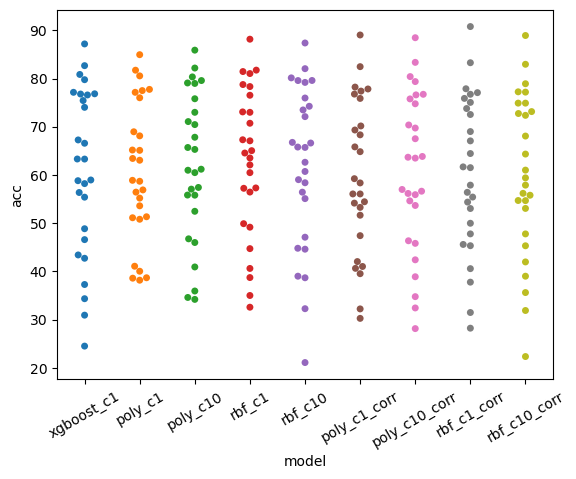

In [58]:
resultsplot = pd.DataFrame(results)
resultsplot = resultsplot.stack().reset_index()
resultsplot = resultsplot.rename(columns = {"level_1":"model", 0:"acc"})


ax = sns.swarmplot(data = resultsplot, x= "model", y = "acc" )
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [ ]:
# ensemble model
# pretrained model?
# MLP on one persons data and train it on everyone else? way too depended on data.
- accuracies > 60 gebruiken
eerst verschillende parameters voor MLP gebruiken, komt het in de buurt?
Daarna spelen met parameters finetunen

In [2]:
# testing initial model on this new data

# initialize dataset 
path_to_dataset = "data"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,             ## what is different in v1? Got no gestures in v2
                                    version="v1", save_df=False, 
                                    remove_transition=True)

df = gr.get_features()


100%|██████████| 2102/2102 [02:26<00:00, 14.31it/s]


In [3]:
subjects = list(df.subject.unique())
subjects.remove("Mario")
subjects.remove("Hanaa")
subjects.remove("Alex")
subjects.remove("David")
subjects.remove("Francisco")

df2 = df[df['subject'].isin(subjects)]
df2.head()

,mav_0,mav_1,mav_2,mav_3,mav_4,mav_5,mav_6,mav_7,rms_0,rms_1,...,iatd_2,iatd_3,iatd_4,iatd_5,iatd_6,iatd_7,gesture,subject,take,iteration
0,1.88,1.72,2.16,5.14,4.54,8.04,4.62,2.24,2.340940,2.097618,...,489.0,1471.0,1103.0,2066.0,1326.0,611.0,ClosedHand,Aarushi,1,0.0
1,2.12,1.84,2.10,4.94,4.58,11.10,5.40,3.02,2.828427,2.441311,...,463.0,1275.0,1263.0,2715.0,1496.0,741.0,ClosedHand,Aarushi,1,0.0
2,2.32,1.84,2.12,4.94,5.50,15.86,8.12,3.96,3.168596,2.433105,...,508.0,1378.0,1396.0,3662.0,2131.0,1015.0,ClosedHand,Aarushi,1,0.0
3,2.38,1.98,2.00,4.88,5.92,16.84,9.30,4.04,3.258834,2.565151,...,476.0,1359.0,1544.0,3959.0,2282.0,1062.0,ClosedHand,Aarushi,1,0.0
4,2.56,2.12,1.88,4.76,6.44,19.50,10.28,4.06,3.492850,2.698148,...,454.0,1344.0,1770.0,4398.0,2274.0,1018.0,ClosedHand,Aarushi,1,0.0


In [4]:
person_test = "Lluis"
df_train = df[(df['subject'] != person_test)]
df_test = df[(df['subject'] == person_test)] 



In [18]:
'''
df2 = df[(df['subject'] == person_test)]
Take_to_test = '1'
df_train = df2[(df2['take'] != Take_to_test)]
df_test = df2[(df2['take'] == Take_to_test)]
'''
df_test.shape

(14528, 60)

In [5]:
model = MLPClassifier(random_state=1,hidden_layer_sizes = 100,max_iter=500)

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.fit(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 45.70%


In [6]:
model2 = model
df2 = df[(df['subject'] == person_test)] 

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

Take_to_train = '1'
df_train = df2[(df2['take'] == Take_to_train)]
df_test = df2[(df2['take'] != Take_to_train)]

X_train2 = df_train[selected_columns]
y_train2 = df_train['gesture']
X_test2 = df_test[selected_columns]
y_test2 = df_test['gesture']

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train2)
y_train2 = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test2)
y_test2 = Y_encoded2 

model2.partial_fit(X_train2, y_train2, classes=np.unique(y_train2))

# making predictions with the testing subset
y_pred = model2.predict(X_test2)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test2, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 70.24%


In [14]:
# testing initial model on this new data

# initialize dataset 
path_to_dataset = "data"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,             ## what is different in v1? Got no gestures in v2
                                    version="v1", save_df=False, 
                                    remove_transition=True)

df = gr.get_features()

  0%|          | 0/2102 [00:00<?, ?it/s]

100%|██████████| 2102/2102 [02:51<00:00, 12.23it/s]


In [27]:
subject = 'Lluis'
Take_to_test = '1'

df2 = df[(df['subject'] == subject)]

In [28]:
## ensemble models

clf1 =  XGBClassifier()
clf2 = SVC(kernel="poly",degree = 2)
clf3 = SVC(kernel="poly",degree = 2, C = 10)
clf4 = SVC(kernel="rbf")
clf5 = SVC(kernel="rbf", C = 10)
clf6 = SVC(kernel="poly",degree = 2, C = 1, class_weight='balanced')
clf7 = SVC(kernel="poly",degree = 2, C = 10, class_weight='balanced')
clf8 = SVC(kernel="rbf", C = 1, class_weight='balanced')
clf9 = SVC(kernel="rbf", C = 10, class_weight='balanced')
clf10 = MLPClassifier(random_state=1,hidden_layer_sizes = 10,max_iter=500)
clf11 = MLPClassifier(random_state=1,hidden_layer_sizes = 50,max_iter=500)



model = VotingClassifier(estimators=[('xgb', clf1), ('poly1', clf2), ('poly10', clf3), ('rbf1', clf4), 
                                     ('rbf10', clf5), ('poly1corr', clf6), ('poly10corr', clf7), ('rbf1corr', clf8), 
                                     ('rbf10corr', clf9), ('MLP10', clf10), ('MLP11', clf11)], voting='hard')

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']


df_train = df2[(df2['take'] != Take_to_test)]
df_test = df2[(df2['take'] == Take_to_test)]

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.fit(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 83.03%
